<a href="https://colab.research.google.com/github/MahmoudFarouq/faceVerification/blob/master/CNN_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Model
from keras.initializers import glorot_uniform
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [0]:
drop = 0.3

In [0]:
def resNetBlock_Identity(X, f, filters, stage, block):
  
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
  
  F1, F2, F3 = filters
  short_cut = X
  
  X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)
  X = Dropout(drop)(X)
  
  X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same' , name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
  X = Activation('relu')(X)
  X = Dropout(drop)(X)
  
  X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
  X = Add()([X, short_cut])
  X = Activation('relu')(X)
  X = Dropout(drop)(X)
  
  return X

In [0]:
def resNetBlock_convolutional(X, f, filters, stage, block, s=2):
  
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
  
  F1, F2, F3 = filters
  short_cut = X
  
  X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)
  X = Dropout(drop)(X)
  
  X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same' , name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
  X = Activation('relu')(X)
  X = Dropout(drop)(X)
  
  X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='same', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
  
  short_cut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid' , name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(short_cut)
  short_cut = BatchNormalization(axis = 3, name = bn_name_base + '1')(short_cut)
  
  X = Add()([X, short_cut])
  X = Activation('relu')(X)
  X = Dropout(drop)(X)
  return X

In [0]:
def ResNet50(input_shape=(48, 48, 3), classes=4):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = resNetBlock_convolutional(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = resNetBlock_Identity(X, 3, [64, 64, 256], stage=2, block='b')
    X = resNetBlock_Identity(X, 3, [64, 64, 256], stage=2, block='c')

    X = resNetBlock_convolutional(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = resNetBlock_Identity(X, 3, [128, 128, 512], stage=3, block='b')
    X = resNetBlock_Identity(X, 3, [128, 128, 512], stage=3, block='c')
    X = resNetBlock_Identity(X, 3, [128, 128, 512], stage=3, block='d')

    X = resNetBlock_convolutional(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='b')
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='c')
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='d')
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='e')
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='f')

    X = resNetBlock_convolutional(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = resNetBlock_Identity(X, 3, [512, 512, 2048], stage=5, block='b')
    X = resNetBlock_Identity(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')
    
    return model

In [11]:
!wget https://github.com/MahmoudFarouq/faceVerification/raw/master/dataSet/dataObject.pkl

--2018-12-29 11:08:36--  https://github.com/MahmoudFarouq/faceVerification/raw/master/dataSet/dataObject.pkl
Resolving github.com (github.com)... 192.30.255.113, 192.30.255.112
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MahmoudFarouq/faceVerification/master/dataSet/dataObject.pkl [following]
--2018-12-29 11:08:37--  https://raw.githubusercontent.com/MahmoudFarouq/faceVerification/master/dataSet/dataObject.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27648166 (26M) [application/octet-stream]
Saving to: ‘dataObject.pkl’

dataObject.pkl      100%[===================>]  26.37M   165MB/s    in 0.2s    

2018-12-29 11:08:37 (165 MB/s) - ‘dat

In [12]:
!ls

dataObject.pkl	sample_data


In [0]:
with open("dataObject.pkl", 'rb') as dataFile:
  X = pickle.load(dataFile)

In [0]:
y = [
    np.full((250, 1), 0), 
    np.full((250, 1), 1), 
    np.full((250, 1), 2), 
    np.full((250, 1), 3)
]
y = np.vstack(y)

# onehot encoding
y_encoder = OneHotEncoder(sparse=False, categories='auto')
y = y_encoder.fit_transform(y)

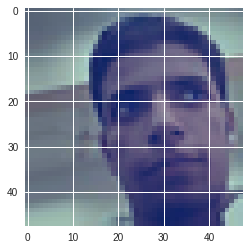

In [15]:
plt.imshow( X[750].reshape(48, 48, 3) )

In [16]:
X.shape, y.shape

((1000, 48, 48, 3), (1000, 4))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
model = ResNet50()

In [0]:
opt = Adam(lr=0.0001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

In [20]:
model.fit(
    X_train, 
    y_train,
    validation_data=(X_test,y_test),
    validation_split=0.8,
    epochs=1000,
    shuffle=True,
    batch_size=128,
    verbose=1
)

Train on 800 samples, validate on 200 samples
Epoch 1/1000
800/800 [==============================] - 21s 26ms/step - loss: 2.1759 - acc: 0.2512 - val_loss: 1.9622 - val_acc: 0.2750
Epoch 2/1000
800/800 [==============================] - 3s 3ms/step - loss: 2.0629 - acc: 0.2500 - val_loss: 2.0101 - val_acc: 0.2750
Epoch 3/1000
800/800 [==============================] - 3s 3ms/step - loss: 1.9663 - acc: 0.2538 - val_loss: 2.0235 - val_acc: 0.2700
Epoch 4/1000
800/800 [==============================] - 3s 3ms/step - loss: 1.9423 - acc: 0.2512 - val_loss: 1.8837 - val_acc: 0.3000
Epoch 5/1000
800/800 [==============================] - 3s 3ms/step - loss: 1.9810 - acc: 0.2500 - val_loss: 1.9811 - val_acc: 0.2300
Epoch 6/1000
800/800 [==============================] - 3s 3ms/step - loss: 1.9505 - acc: 0.2487 - val_loss: 1.8962 - val_acc: 0.2450
Epoch 7/1000
800/800 [==============================] - 3s 3ms/step - loss: 1.8360 - acc: 0.2888 - val_loss: 1.8365 - val_acc: 0.2800
Epoch 8/1000
8

In [0]:
names = ['karim', 'omar', 'amr', 'farouq']

In [30]:
model.evaluate(X_test, y_test)

200/200 [==============================] - 0s 1ms/step


[1.483606014251709, 0.77]

'amr'

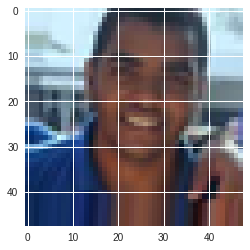

In [63]:
index = np.random.randint(0, 200)
plt.imshow(X_test[index].reshape(48, 48, 3))
names[np.argmax(model.predict(X_test[index].reshape(1, 48, 48, 3)))]

In [64]:
print("train acc: ", np.sum(np.argmax(model.predict(X_train), axis=1) == np.argmax(y_train, axis=1)) / 800)

train acc:  0.95875


In [65]:
print("test acc: ", np.sum(np.argmax(model.predict(X_test), axis=1) == np.argmax(y_test, axis=1)) / 200)

test acc:  0.765


In [0]:
model.save("model.mdl")

In [68]:
!ls

dataObject.pkl	model.mdl  sample_data


In [0]:
from keras.models import load_model

In [0]:
m = load_model("model.mdl")

('amr', 'amr')

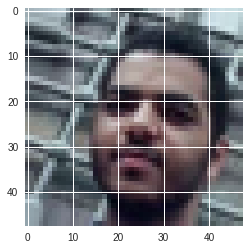

In [131]:
index = np.random.randint(0, 800)
plt.imshow(X_train[index].reshape(48, 48, 3))
names[np.argmax(model.predict(X_train[index].reshape(1, 48, 48, 3)))], names[np.argmax(y_train[index])]